In [289]:
legi: "19-747-096"

# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [290]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
import scipy.sparse as sparse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

from scipy.optimize import linear_sum_assignment

from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

from typing import Tuple

The number of nodes is hardcoded for simplicity (taken from [2]):

In [291]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [292]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [293]:
print(np.unique(DATA, return_counts=True))

(array([0., 1.]), array([977255,  32770]))


In [294]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
        self.S_tilde_c = None
        # need also S_c as it was used in Figure 4 of [1]
        self.S_c = None
        D_tilde = None
        
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        
        # ------------------------------------------------------------------- #
        #                       Constant Shift Embedding                      #
        # ------------------------------------------------------------------- #
        
        ## IMPLEMENT THIS METHOD
        # see: https://math.stackexchange.com/questions/724158/shortest-distance-matrix-given-an-adjacency-matrix
        self.D = sparse.csgraph.shortest_path(sparse.csr_matrix(PMAT), directed=False, unweighted=True)
        # if there is no path between two nodes, the distance is infinite; thus have to replace it with a large number
        print(f"{self.D[self.D != np.inf].max()=}") # 7
        self.D[self.D == np.inf] = self.D[self.D!=np.inf].max() + 5.0
        
        # symmetrize (should already be symmeteric as underlying adjacency matrix is symmetric)
        D_s = 0.5 * (self.D + self.D.T)
        
        assert np.all(D_s == D_s.T), "D_s is not symmetric"

        
        # centralize dissimilarity matrix; note that self.D.shape[0] is the same as NUM_NODES
        I_n = np.eye(self.D.shape[0])
        e_n = np.ones((self.D.shape[0], 1))
        Q = I_n - 1 / self.D.shape[0] * e_n @ e_n.T
        D_c = Q @ D_s @ Q
        
        assert D_c.sum(axis=0).sum() < 1e-9, "D_c is not centered"
        assert D_c.sum(axis=1).sum() < 1e-9, "D_c is not centered"
        
        
        # compute Gram matrix:
        self.S_c = -0.5 * D_c
        # compute minimum eigenvalue of S_c
        # note that due to the symmetry of S_c, we can use eigh instead of eigs
        # eigh alsao orders the eigenvalues in ascending order by default:
        eigenvalues = la.eigvalsh(self.S_c)
        min_eigenvalue = eigenvalues[0]
        
        # use D~ = S_ii~ + S_jj~ - 2 * S_ij~ to get squared Euclidean distance matrix
        S_tilde = self.S_c - min_eigenvalue * I_n
        S_tilde_diag = np.diag(self.S_c)
        D_tilde = S_tilde_diag[:, None] + S_tilde_diag[None, :] - 2 * S_tilde
        
        ## Alternatively (for reference):
        # as in [1], we can alternatively also use D~ = D_symm - 2 * λ_n(S_c) * (e_n * e_n^T - I_n)
        #D_tilde = D_s - 2 * min_eigenvalue * (e_n @ e_n.T - I_n)
        

        
        
        
        # ------------------------------------------------------------------- #
        #                 Preparations for get_embedded_vectors:              #
        # ------------------------------------------------------------------- #
        # centralize squared Euclidean distance matrix:
        D_tilde_c = Q @ D_tilde @ Q
        
        # compute Gram matrix:
        self.S_tilde_c = -0.5 * D_tilde_c
        
        
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        ## IMPLEMENT THIS METHOD
        # sorting the eigenvalues:
        # see: https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
        eigenvalues, eigenvectors = la.eigh(self.S_tilde_c)
        indices = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]
        
        # make sure are eigenvalues are non-negative
        eigenvalues = np.maximum(eigenvalues, 0)
        
        
        # extract first p eigenvalues and eigenvectors
        # as mentioned in 1, only the first p eigenvalues are non-zero. Using
        # these first p eigenvectors and eigenvalues, we can achieve loss-free
        # reconstruction. Denoising can be achieved by using t<p.
        t = min(p, np.sum(eigenvalues > 0)) # only consider non-zero eigenvalues
        t=p
        V_p = eigenvectors[:, :t]
        Lambda_p = np.diag(eigenvalues)[:t]
        
        X_p = V_p @ np.sqrt(Lambda_p)
        
        S_tilde = X_p @ X_p.T
        S_tilde_diag = np.diag(S_tilde)
        
        D_tilde = S_tilde_diag[:, None] + S_tilde_diag[None, :] - 2 * S_tilde
        # squared Euclidan distance cannot be negative -> clamp
        D_tilde = np.maximum(D_tilde, 0)
        
        print(f"{np.sum(D_tilde < 0)=}")
        
        return X_p, D_tilde


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: As motivated in the lecture and in [1], in many clustering problems the observed objects are not represented as vectors in vector spaces but instead by pairwise dissimilarity matrices. In this setting we can make use of Constant Shift Embedding to find a mapping $i \mapsto x_i$ such that the pairwise distances between these embeddings can be represented as $D_{ij}=||x_i-x_j||^2$. In a second step, we can then e.g. apply a clustering algorithm to the embeddings $x_i$ to find the clusters in the original data. The main steps of the CSE algorithm for calculating the embeddings given a dissimilarity matrix $D$ are as follows:
  
1. **Symmetrize Dissimilarity Matrix:**$\quad D^s = 0.5\cdot(D + D^{\top})$
2. **Centralize $D^s$:** $\quad D^c = (I_n - \dfrac{1}{n}e_n e_n^{\top})D^s (I_n - \dfrac{1}{n}e_n e_n^{\top}),$ where $e_n$ is a vector of ones of length $n$ and $I_n$ is the $n\times n$ identity matrix.
3. **Compute Gram Matrix:** $\quad S^c = -0.5\cdot D^c$
4. **Make $S^c$ Positive Semi-Definite:** $\quad \tilde{S} = S^c -\lambda_n(S^c)I_n,$ where $\lambda_n(S^c)$ is the smallest eigenvalue of $S^c$ and $I_n$ is the $n\times n$ identity matrix. Moreover, as discussed in the tutorial, since $\tilde{S}$ is positive semi-definite, we can find a matrix $X$ such that $\tilde{S} = XX^{\top}$.
5. **Shift Off-diagonal Elements of $\tilde{S}$:** $\quad\tilde{D}_{ij}=\tilde{S}_{ii} + \tilde{S}_{jj} - 2\cdot \tilde{S}_{ij}.\quad$ As mentioned in [1], this matrix $\tilde{D}$ derives  from a squared Euclidean matrix. Moreover, one can alternatively use equivalence (15) in [1] to calculate $\tilde{D}$ using $\tilde{D}= D - 2\cdot \lambda_n(S^c)(e_ne_n^{\top}-I_n),\quad$ where again $\lambda_n(S^c)$ is the smallest eigenvalue of $S^c$, $I_n$ is the $n\times n$ identity matrix and $e_n$ is a vector of ones of length $n$.

Additionally, using the following algorithm described in [1] we can also recover the vectors $\{x_i\}_{i=1}^n$ from an eigenvalue decomposition of the matrix $\tilde{S^c}$, which can be calculated after all the above listed CSE steps have been completed:

1. **Compute Gram matrix:** $\quad \tilde{S}^c = -0.5\cdot \tilde{D}^c$
2. **Diagonalize $\tilde{S}^c$:** $\quad \tilde{S}^c = V\Lambda V^{\top},$ where $U$ is the matrix of eigenvectors and $\Lambda$ is the diagonal matrix of ordered eigenvalues $\lambda_1\geq\lambda_{2}\geq\cdots\lambda_p>\lambda_{p+1}=0=\cdots=\lambda_n$.
3. **Loss-free Reconstruction:** $\quad X_p = V_p(\Lambda_p)^{1/2}, \quad$ where $V_p$ is the matrix of the first $p$ eigenvectors and $\Lambda_p$ is the diagonal matrix of the first $p$ eigenvalues. As mentioned in [1], the rows of $X_p$ are vectors in a $p$-dimensional space whose pairwise distances are encoded in $\tilde{D}$.
4. **Approximation and Denoising**: $\quad X_t = V_t(\Lambda_t)^{1/2}, \quad t<p. \quad$ The idea behind this step is to separate the noise from the signal.

<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [295]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [296]:
CSE.fit(DATA)

self.D[self.D != np.inf].max()=7.0


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [297]:
## Compute eigen-spectrum
eigen_spectrum = np.maximum(np.linalg.eigvalsh(CSE.S_c)[::-1], 0.0)
eigen_spectrum_change = eigen_spectrum[:-1] - eigen_spectrum[1:]

In [298]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 60 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  60


First, note that the eigenvalues are influenced by our choice of the fill value of the infinite entries in the data matrix that occur due to some nodes not being connected. I used a large number (self.D[self.D == np.inf] = self.D[self.D!=np.inf].max() + 5.0; this evaluates to 12.0) to fill the infinite entries. Hence, my choice of $p^∗$ most likely is different from the one you get when using a different fill value.

Having said that, based on the eigen-spectrum plot, I identified the optimal $p^∗$ as the point where the eigenvalues start to decrease rapidly (i.e. the elbow point). That is, I chose $p^*$ to be 15 due to the sudden drop in the change of eigen-spectrum after the 15-th eigenvalue.

Text(0, 0.5, 'Change of Eigenvalue (Scale Limited to 2)')

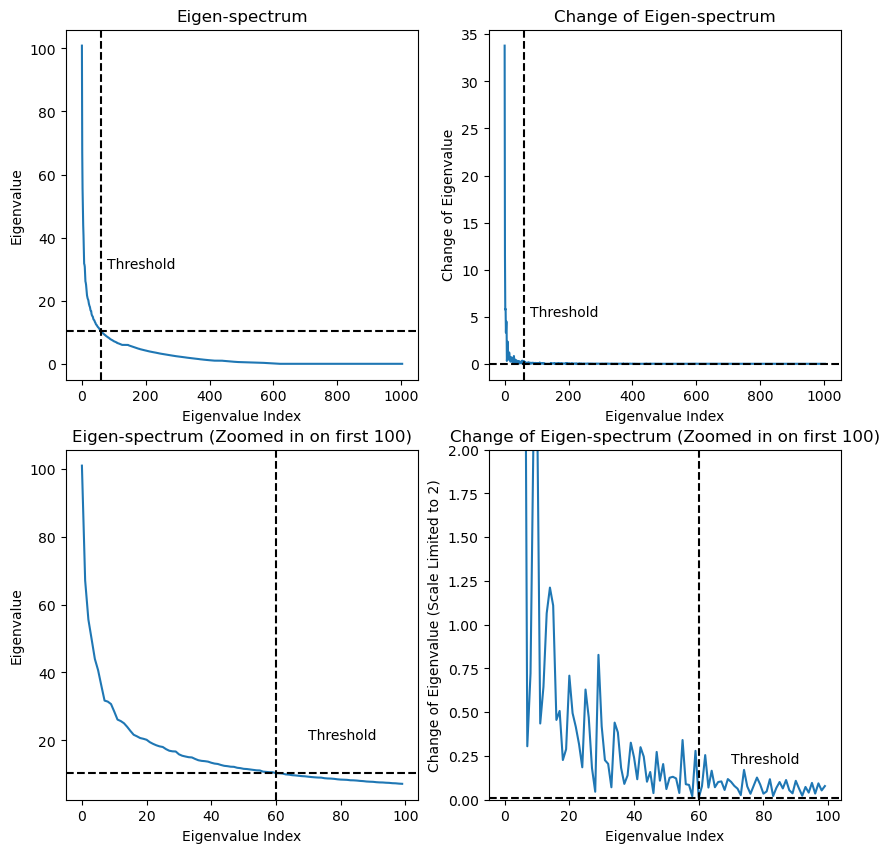

In [299]:
## Plot spectrum and indicate the cut-off value on the spectrum
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(eigen_spectrum, linestyle = "-")
ax[0, 0].axvline(x = p_opt, color = "black", linestyle = "--")
ax[0, 0].annotate("Threshold", (p_opt + 20, eigen_spectrum[p_opt] + 20))
ax[0, 0].axhline(y = eigen_spectrum[p_opt], color = "black", linestyle = "--")
ax[0, 0].set_title("Eigen-spectrum")
ax[0, 0].set_xlabel("Eigenvalue Index")
ax[0, 0].set_ylabel("Eigenvalue")

ax[0, 1].plot(eigen_spectrum_change, '-')
ax[0, 1].axvline(x = p_opt, color = "black", linestyle = "--")
ax[0, 1].annotate("Threshold", (p_opt + 20, eigen_spectrum_change[p_opt] + 5))
ax[0, 1].axhline(y = eigen_spectrum_change[p_opt], color = "black", linestyle = "--")
ax[0, 1].set_title("Change of Eigen-spectrum")
ax[0, 1].set_xlabel("Eigenvalue Index")
ax[0, 1].set_ylabel("Change of Eigenvalue")

ax[1, 0].plot(eigen_spectrum[:100], '-')
ax[1, 0].axvline(x = p_opt, color = "black", linestyle = "--")
ax[1, 0].annotate("Threshold", (p_opt + 10, eigen_spectrum[p_opt] + 10))
ax[1, 0].axhline(y = eigen_spectrum[p_opt], color = "black", linestyle = "--")
ax[1, 0].set_title("Eigen-spectrum (Zoomed in on first 100)")
ax[1, 0].set_xlabel("Eigenvalue Index")
ax[1, 0].set_ylabel("Eigenvalue")

ax[1, 1].set_ylim(0, 2)
ax[1, 1].plot(eigen_spectrum_change[:100], '-')
ax[1, 1].axvline(x = p_opt, color = "black", linestyle = "--")
ax[1, 1].annotate("Threshold", (p_opt + 10, eigen_spectrum_change[p_opt] + 0.2))
ax[1, 1].axhline(y = eigen_spectrum_change[p_opt], color = "black", linestyle = "--")
ax[1, 1].set_title("Change of Eigen-spectrum (Zoomed in on first 100)")
ax[1, 1].set_xlabel("Eigenvalue Index")
ax[1, 1].set_ylabel("Change of Eigenvalue (Scale Limited to 2)")

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [300]:
## Distance matrices
X_p_opt, D_tilde_p_opt = CSE.get_embedded_vectors(p_opt)
X_orig, D_tilde_orig = CSE.get_embedded_vectors(NUM_NODES - 1)

# get Euclidean distances from squared Euclidean distances
D_tilde_orig = np.sqrt(D_tilde_orig)
D_tilde_p_opt = np.sqrt(D_tilde_p_opt)

np.sum(D_tilde < 0)=0
np.sum(D_tilde < 0)=0


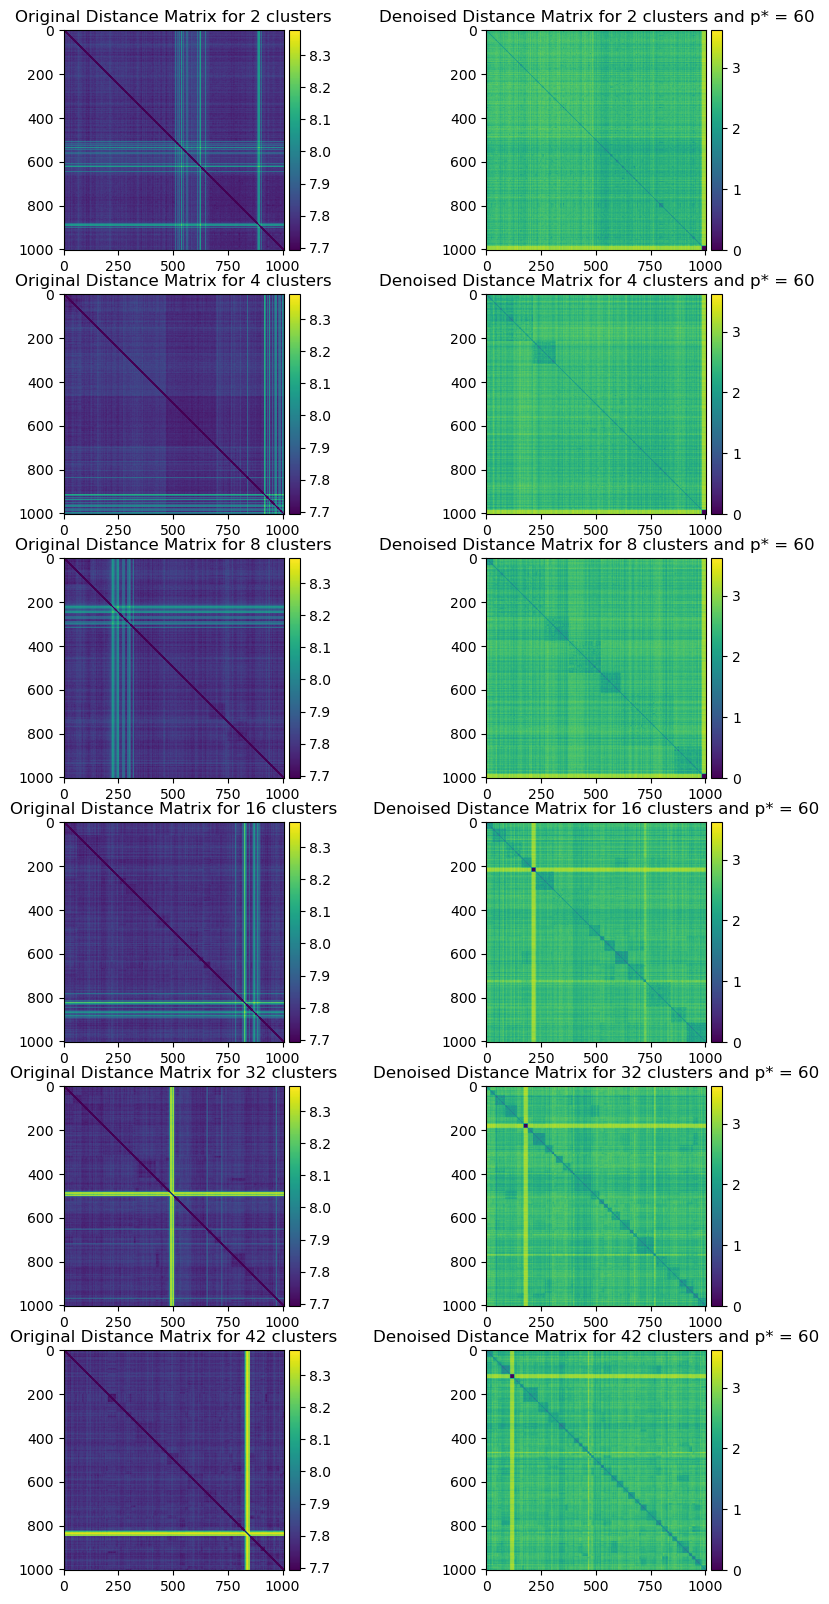

In [301]:
n_clusters_list = [2, 4, 8, 16, 32, 42]

fig, ax = plt.subplots(len(n_clusters_list), 2, figsize=(10, 20))

for i, n_clusters in enumerate(n_clusters_list):
    # calculate clusters:
    p_opt_clusters = KMeans(
        n_clusters=n_clusters, random_state=42, n_init=10
    ).fit_predict(X_p_opt)
    orig_clusters = KMeans(
        n_clusters=n_clusters, random_state=42, n_init=10
    ).fit_predict(X_orig)

    # Reorder the distance matrix by clusters
    indices_p_opt = np.argsort(p_opt_clusters)
    reordered_matrix_p_opt = D_tilde_p_opt[indices_p_opt, :][:, indices_p_opt]

    indices_orig = np.argsort(orig_clusters)
    reordered_matrix_orig = D_tilde_orig[indices_orig, :][:, indices_orig]

    # see: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # for a guide on how to make colorbar size match plot size
    im = ax[i, 0].imshow(
        reordered_matrix_orig,
        cmap="viridis",
        vmin=reordered_matrix_orig[reordered_matrix_orig != 0.0].min(),
    )
    ax[i, 0].set_title(f"Original Distance Matrix for {n_clusters} clusters")
    divider = make_axes_locatable(ax[i, 0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

    # see: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # for a guide on how to make colorbar size match plot size
    im = ax[i, 1].imshow(reordered_matrix_p_opt, cmap="viridis")
    ax[i, 1].set_title(
        f"Denoised Distance Matrix for {n_clusters} clusters and p* = {p_opt}"
    )
    divider = make_axes_locatable(ax[i, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

First, note that due to the nature of the shortest path dissimilarity, all diagonal elements in the original distance matrix as well as the denoised distance matrix are zero. Since most of the off-diagonal elements in the original distance matrix are substantially larger than zero, I had to adjust the colorbar limits to make the differences in the off-diagonal elements more visible.

<span style="color:red">Add interpretation</span>. higher dimensions -> higher distances?

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [302]:
## Get embeddings, run K-MEANS and generate plots

In [303]:
## p = 2

In [304]:
## p = 3

In [305]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [306]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [307]:
np.unique(AFFILIATIONS, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41.]),
 array([ 49,  65,  10,  12, 109,  18,  28,  51,  19,  32,  39,  29,   3,
         26,  92,  55,  25,  35,   1,  29,  14,  61,  25,  27,   6,   6,
          9,  10,   8,   5,   4,   8,   9,   1,  13,  13,  22,  15,  13,
          3,   4,   2]))

Since the cluster sizes in the ground truth are imbalanced, we can use the balanced accuracy score as a measure of the clustering quality. Additionally, I will report the accuracy score to highlight the overall performance of the clustering algorithm when not accounting for the imbalanced cluster sizes.

In [308]:
# This function is an adapted version from my solution for the second coding
# exercise of the Statistical Learning Theory course
def calculate_cm(
    true_labels: np.ndarray, predicted_labels: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    # see link below for cost matrix
    # https://stackoverflow.com/questions/69762777/hungarian-algorithm-for-change-of-matrix
    costs = -confusion_matrix(true_labels, predicted_labels)
    costs -= costs.min()
    true, predicted = linear_sum_assignment(costs)
    # dictionary with predicted label as keys and labels of true (permuted) texture
    # as value
    label_dct = {pred: true for pred, true in zip(predicted, true)}
    remapped_preds = np.array([label_dct[i] for i in predicted_labels])
    cm = confusion_matrix(true_labels, remapped_preds)
    return cm, remapped_preds

In [309]:
## Here you can provide plots and calculations
X_p_opt, _ = CSE.get_embedded_vectors(p_opt)

kmeans = KMeans(n_clusters=42, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_p_opt)

np.sum(D_tilde < 0)=0


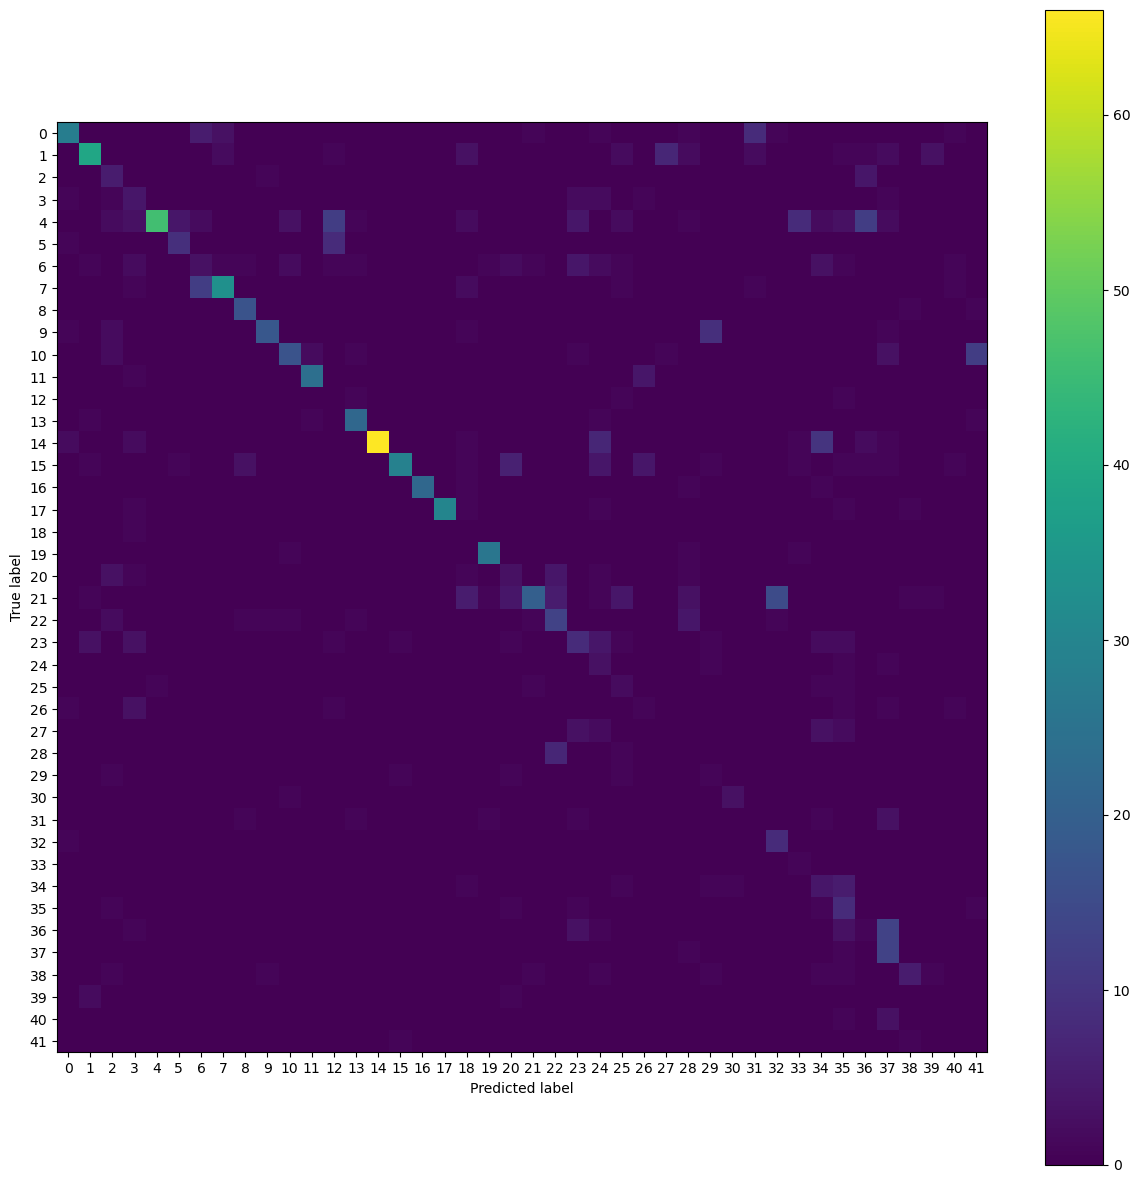

In [310]:
cm, remapped_preds = calculate_cm(AFFILIATIONS, clusters)
# see: https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
disp = ConfusionMatrixDisplay(cm).plot(include_values=False)
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

In [311]:
bal_acc = balanced_accuracy_score(AFFILIATIONS, remapped_preds)
acc = accuracy_score(AFFILIATIONS, remapped_preds)

print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Accuracy: {acc:.4f}")

Balanced accuracy: 0.4402
Accuracy: 0.5294


In [312]:
# see: https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
clust_acc = np.c_[cm.diagonal() / cm.sum(axis=1), np.unique(AFFILIATIONS, return_counts=True)[1]]
clust_acc = clust_acc[clust_acc[:, 1].argsort()[::-1]]
np.set_printoptions(suppress=True)
print(f"Cluster accuracies sorted by true cluster size:\n Accuracy   Cluster size\n{np.round(clust_acc,3 )}")

Cluster accuracies sorted by true cluster size:
 Accuracy   Cluster size
[[  0.422 109.   ]
 [  0.717  92.   ]
 [  0.6    65.   ]
 [  0.328  61.   ]
 [  0.527  55.   ]
 [  0.647  51.   ]
 [  0.571  49.   ]
 [  0.436  39.   ]
 [  0.857  35.   ]
 [  0.562  32.   ]
 [  0.897  29.   ]
 [  0.828  29.   ]
 [  0.107  28.   ]
 [  0.296  27.   ]
 [  0.846  26.   ]
 [  0.88   25.   ]
 [  0.52   25.   ]
 [  0.045  22.   ]
 [  0.895  19.   ]
 [  0.5    18.   ]
 [  0.867  15.   ]
 [  0.214  14.   ]
 [  0.308  13.   ]
 [  0.385  13.   ]
 [  0.615  13.   ]
 [  0.333  12.   ]
 [  0.     10.   ]
 [  0.5    10.   ]
 [  0.111   9.   ]
 [  0.889   9.   ]
 [  0.      8.   ]
 [  0.      8.   ]
 [  0.5     6.   ]
 [  0.333   6.   ]
 [  0.2     5.   ]
 [  0.      4.   ]
 [  0.75    4.   ]
 [  0.      3.   ]
 [  0.      3.   ]
 [  0.      2.   ]
 [  1.      1.   ]
 [  0.      1.   ]]


It is apparent that the balanced accuracy score is almost 10% lower than the accuracy score. A closer look at the above depicted per class accuracies then reveals that this discrepancy is due to the low accuracy in the classes with fewer samples.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.